# Basic pre-processing pipeline

The following is the minimal preprocessing pipeline to be applied to EMGs for analysis. This is meant to create the EMG that all other pre-processing steps are added over

## Import libraries

In [1]:
# %matplotlib widget
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import math
import resurfemg.helper_functions as hf
import resurfemg.converter_functions as cf
from resurfemg.config import Config
config = Config()
from resurfemg.tmsisdk_lite import Poly5Reader


C:\Users\makeda\anaconda3\envs\blank\envs\emg_half_conda\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\blank\envs\emg_half_conda\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\blank\envs\emg_half_conda\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [2]:
# ### pulling from local
# sys.path.insert(0, '../resurfemg')
# import helper_functions as hf
# from config import Config
# from tmsisdk_lite import Poly5Reader
# config = Config()

To work with local resurfemg import as in cell below, otherwise, just use the current version i.e. import eegyolk.helper_functions as hf

In [3]:
# load up sample EEGs to show results
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

In [4]:
root_emg_directory = config.get_directory('root_emg_directory')

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)


Now you can pick a file from the list, which have been numbered 0-35.

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))

btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [7]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen]
print(file_chosen)

C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [8]:
data_emg = Poly5Reader(file_chosen)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)

Reading file  C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


In [9]:
print(type(data_samples))

<class 'numpy.ndarray'>


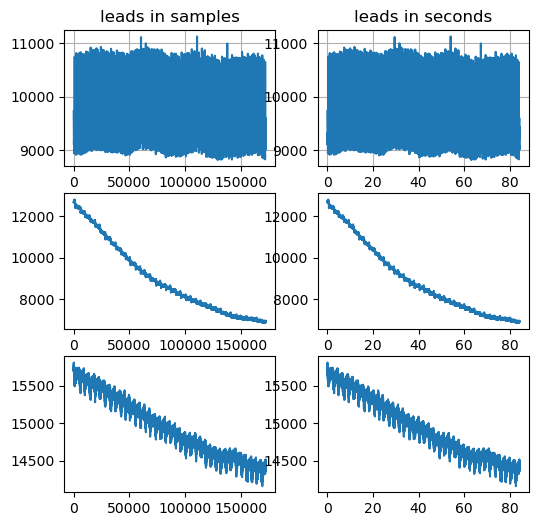

In [10]:
%matplotlib inline
# set up plot
x = data_samples
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))
axis[0, 0].grid(True)
axis[0, 0].plot(x[0])
axis[0, 0].set(title='leads in samples')
axis[1, 0].plot(x[1])
axis[2, 0].plot(x[2])
axis[0, 1].set(title='leads in seconds')
axis[0, 1].grid(True)
axis[0, 1].plot(converted_to_seconds, x[0])
axis[1, 1].plot(converted_to_seconds, x[1])
axis[2, 1].plot(converted_to_seconds, x[2])

That is the whole unfiltered EMG, now we want a basic preprocessing pipeline that gives us the EMG signal.

Here we use the minimal_pipline function from helper_functions. Note it is currently the following:
    
    def minimal_pipeline(our_chosen_file, heart_lead_number, frequency):
    """
    Here we have a minimal basic pre-processing pipeline. Note 
    heart leads should be counted in Python numbering
    i.e. lead number one is zero. 
    """
    # step 1 cut off any wierd end
    cut_file_data = bad_end_cutter_for_samples(
        our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    # step 2 minimal filtering    
    bd_filtered_file_data = emg_bandpass_butter_sample(
        cut_file_data, 5, 450, frequency, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = bad_end_cutter_for_samples(
        bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = compute_ICA_two_comp(re_cut_file_data)
    #     the secret hidden step!
    ecg_lead = re_cut_file_data[heart_lead_number]
    emg = pick_lowest_correlation_array(components, ecg_lead)
    return emg

In [11]:
def minimal_ecg_pipeline(our_chosen_file, heart_lead_number, frequency):
    """
    Here we have a minimal basic pre-processing pipeline. Note 
    heart leads should be counted in Python numbering
    i.e. lead number one is zero. 
    """
# step 1 cut off any wierd end
    cut_file_data = hf.bad_end_cutter_for_samples(
        our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    # step 2 minimal filtering    
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(
        cut_file_data, 1, frequency/2.1, frequency, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(
        bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the secret hidden step!
    ecg_lead = re_cut_file_data[heart_lead_number]
    emg = hf.pick_lowest_correlation_array(components, ecg_lead)
    ecg = hf.pick_lowest_correlation_array(components, emg)
    return ecg

In [12]:
x = minimal_ecg_pipeline(data_samples,0, 2048)

C:\Users\makeda\anaconda3\envs\blank\envs\emg_half_conda\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


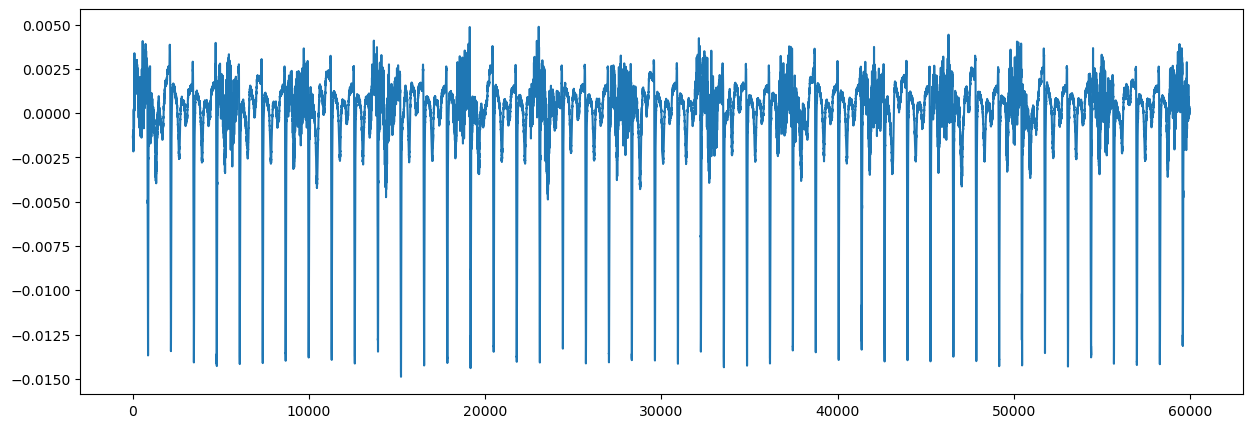

In [13]:
#graph out results

start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(x[int(start):int(end)])


In [14]:
## Preprocessing for ECG signal

In [15]:
e = minimal_ecg_pipeline(data_samples,0, 2048)

C:\Users\makeda\anaconda3\envs\blank\envs\emg_half_conda\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


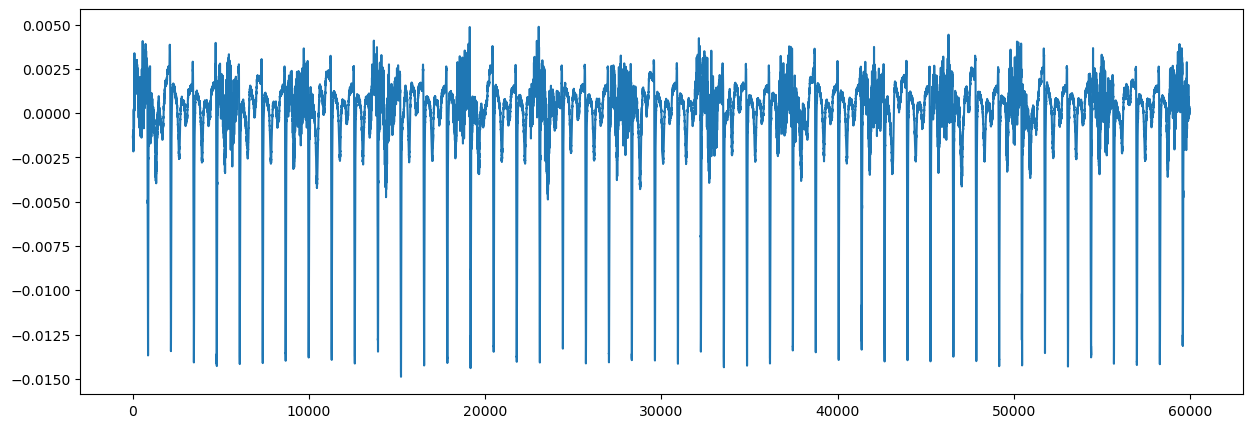

In [16]:
start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(e[int(start):int(end)])


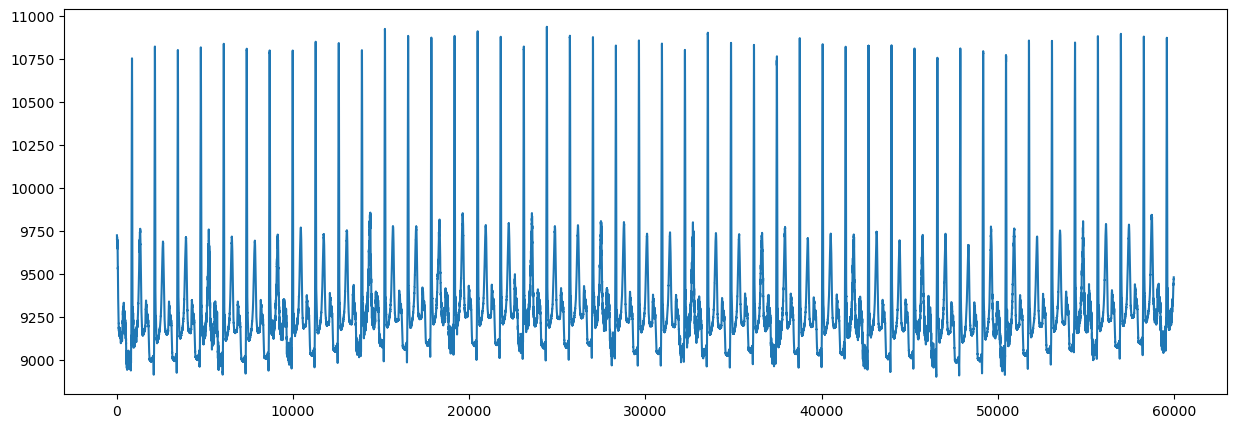

In [17]:
start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(data_samples[0][int(start):int(end)])

Here we note the heart lead seems to give us a better ECG than mixing all the components and then extracting the heart lead with an ICA. Needs more reseach.